### VGG 16 pytorch implementation


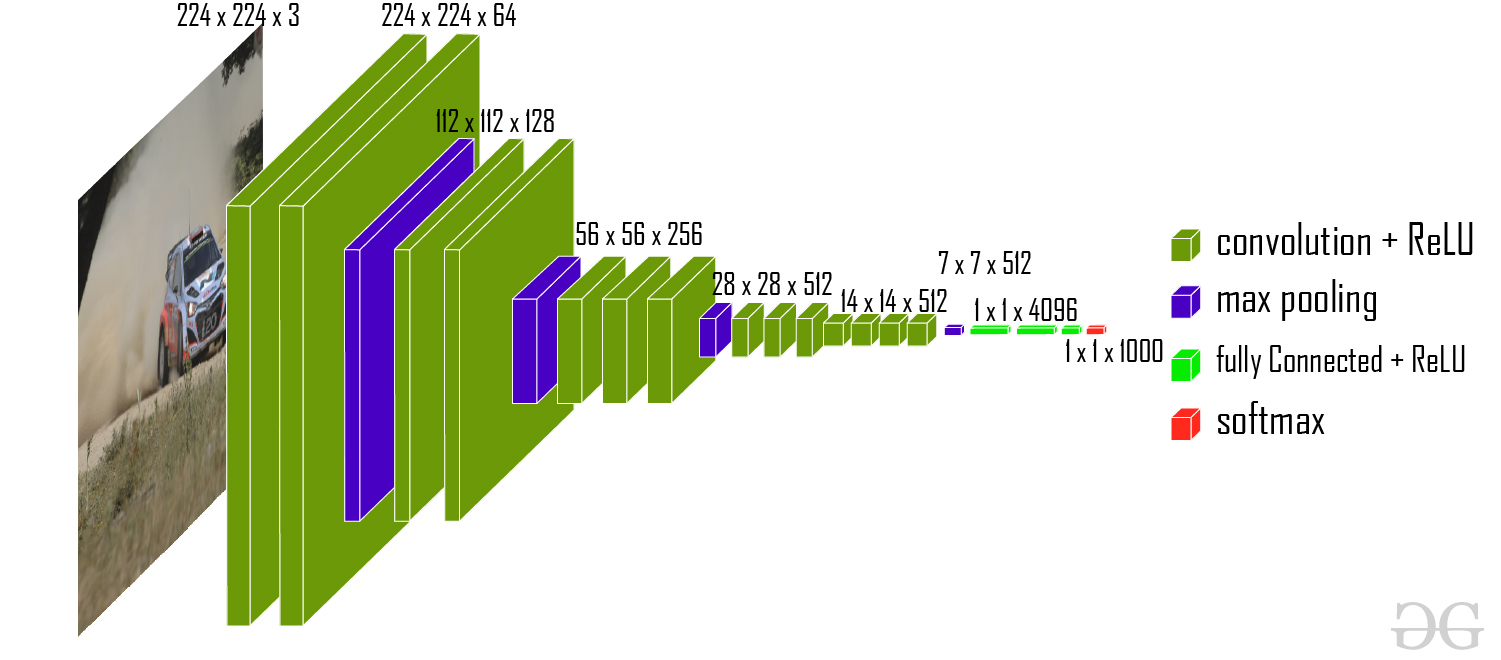

In [ ]:
import torch, torchvision
from torch import nn
from torch import optim
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
VGG_Architectures = {
    "VGG16" : [ 64,64,"M",128,128,"M",256,256,256,"M",512,512,512,"M",512,512,512,"M",],
    "VGG19" : [ 64,64,"M",128,128,"M",256,256,256,256,"M",512,512,512,512,"M",512,512,512,512,"M",]
}

In [ ]:
VGG16 = VGG_Architectures["VGG19"]

### VGG 16 : 
###### (n+2p-f+1)/s + 1
###### 224x224 :(64 conv) 224+2-3+1 : 224X224 
###### 224x224 :(64 conv) 224+2-3+1 : 224X224 
###### 224x224 :(maxpool) (224-2+1)/2 + 1 : 112X112 
###### 122x122 :(128 conv) 122+2-3+1 : 122X122 
###### 122x122 :(128 conv) 122+2-3+1 : 122X122
###### 122x122 :(maxpool) (122-2+1)/2 + 1 : 56X56
###### 56x56 :(256 conv) 56+2-3+1 : 56X56
###### 56x56 :(256 conv) 56+2-3+1 : 56X56
###### 56x56 :(256 conv) 56+2-3+1 : 56X56
###### 56X56 :(maxpool) (56-2+1)/2 + 1 : 28X28
###### 28x28 :(512 conv) 28+2-3+1 : 28X28
###### 28x28 :(512 conv) 28+2-3+1 : 28X28
###### 28x28 :(512 conv) 28+2-3+1 : 28X28
###### 28X28 :(maxpool) (28+2-3+1)/2 + 1 : 14X14
###### 14X14 :(512 conv) 14+2-3+1 : 14X14
###### 14X14 :(512 conv) 14+2-3+1 : 14X14
###### 14X14 :(512 conv) 14+2-3+1 : 14X14
###### 24X14 :(maxpool) (28+2-3+1)/2 + 1 : 7x7
###### SINGLE : 7X7X512

In [ ]:
class VGGXX(nn.Module):
  def __init__(self, in_channels = 3, num_classes = 1000):
    super(VGGXX,self).__init__() #call nn constructor
    self.in_channels = in_channels
    self.num_classes = num_classes
    self.conv_layers = self.createConvLayers(VGG16)
    self.fcs = nn.Sequential(
        nn.Linear(512*7*7, 4096),
        nn.ReLU(),
        nn.Dropout(p = 0.5),
        nn.Linear(4096,4096),
        nn.ReLU(),
        nn.Dropout(p = 0.5),
        nn.Linear(4096,num_classes)
    )
  def forward(self,x):
    x = self.conv_layers(x) #512x7x7 is going to be output of x
    x = x.reshape(x.shape[0],-1)
    x = self.fcs(x) ## this gives the final layer.
    return x

  def createConvLayers(self,architecture):
    in_channels = self.in_channels
    layers = []
    for l in architecture :
      if(type(l) == int) :
        layers += [nn.Conv2d(in_channels = in_channels, out_channels = l, kernel_size=(3,3), stride= (1,1), padding=(1,1)), nn.BatchNorm2d(l),nn.ReLU(),]
        in_channels = l # next layer input is going to be this layer ka output channels ke barabar.
      else :
        #Max pool layer
        layers += [nn.MaxPool2d(kernel_size=(2,2),stride = (2,2))]
        
    return nn.Sequential(*layers) #unpack and send.

In [ ]:
if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = VGGXX(in_channels=3, num_classes=1000).to(device)
    BATCH_SIZE = 16
    x = torch.randn(BATCH_SIZE, 3, 224, 224).to(device)
    assert model(x).shape == torch.Size([BATCH_SIZE, 1000])
    print(model(x).shape)

torch.Size([16, 1000])


In [ ]:
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data_utils
transform = transforms.Compose(
    [transforms.Resize((224,224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
print(len(trainset.data))

Files already downloaded and verified
50000


[DATA LOADING TUT](https://towardsdatascience.com/beginners-guide-to-loading-image-data-with-pytorch-289c60b7afec)

In [ ]:
import torchvision
import torchvision.transforms as transforms
transform = transforms.Compose(
    [transforms.Resize((224,224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(torch.utils.data.Subset(trainset,range(int(len(trainset.data)*1))), batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(torch.utils.data.Subset(testset,range(int(len(testset.data)*1))), batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
print(len(trainloader))

12500


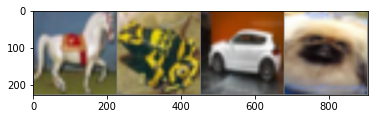

horse frog  car   dog  


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
def validate(model, data):
    total = 0
    correct = 0
    for i, (images, labels) in enumerate(testloader):
        images = images
        x = model(images)
        value, pred = torch.max(x,1)
        total += x.size(0)
        correct += torch.sum(pred == labels)
    return correct*100./total

In [ ]:
def train(numb_epoch=3, lr=1e-2, device="cpu"):
    accuracies = []
    cnn = VGGXX(num_classes = 10)
    cec = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=lr)
    max_accuracy = 0
    for epoch in range(numb_epoch):
        for i, (images, labels) in enumerate(trainloader):
            print(epoch, " : ", i)
            images = images
            labels = labels
            
            optimizer.zero_grad() # reset the gradients.

            # forward + backward + optimize
            pred = cnn(images)
            loss = cec(pred, labels)
            loss.backward()
            optimizer.step()

        accuracy = float(validate(cnn, testloader))
        accuracies.append(accuracy)
        print('Epoch:', epoch+1, "Accuracy :", accuracy, '%')
    plt.plot(accuracies)

In [ ]:
device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("No Cuda Available")
device

device(type='cuda', index=0)

In [ ]:
train()